In [1]:
from sklearn.linear_model import LinearRegression, RidgeCV, BayesianRidge, Ridge
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

INPUT_PATH = Path("/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize")
OUTPUT_PATH = Path("/mnt/storage/kaggle_output/commonlitreadabilityprize")

In [2]:
model_folders = [
    # complex-heron-of-science - roberta-base
    "20210609-171109",
    "20210609-174639",
    "20210609-182121",
    "20210609-192843",
    "20210609-200242",
    # impetuous-marvellous-cockle - roberta-large
    "20210608-233655",
    "20210609-004922",
    "20210609-020213",
    "20210609-205046",
    "20210609-220344",
    # zippy-caped-leech - albert-large
    "20210609-125306",
    "20210609-141352",
    "20210609-154233",
    "20210610-000227",
    "20210610-013100",
    # armored-cobalt-crow - distill roberta
    "20210610-074205",
    "20210610-080716",
    "20210610-083206",
    "20210610-085718",
    "20210610-093912",
    # big-slug-of-tranquility - funnel transformer
    "20210610-100607",
    "20210610-111551",
    "20210610-122301",
    "20210610-133140",
    "20210610-144044",
    # nocturnal-winged-lionfish - bert-base-uncased
    "20210610-184414",
    "20210610-191826",
    "20210610-195230",
    "20210610-202640",
    # adaptable-scallop-of-anger - roberta-base (hidden)
    "20210610-222705",
    "20210610-230256",
    "20210610-233847",
    "20210611-001430",
    "20210611-005055",
    # fluffy-dandelion-skua - roberta-large (hidden)
    "20210611-012655",
    "20210611-024254",
    "20210611-035830",
    "20210611-051501",
    "20210611-063430",
    # gregarious-classic-yak - albert-large (hidden)
    "20210611-080150",
    "20210611-092625",
    "20210611-105105",
    "20210611-121556",
    "20210611-134040",
    # serious-outrageous-caribou - deberta-base
    "20210611-151313",
    "20210611-155942",  # This seed seems amazing
    "20210611-164611",
    "20210611-173302",
    "20210611-182030",
    # ostrich-of-abstract-art - deberta-large
    "20210611-191919",
    "20210611-212749",
    "20210611-233646",
    "20210612-014457",
    "20210612-035134",
]

dataset_paths = [OUTPUT_PATH / f for f in model_folders]

In [3]:
mpaths, oof_paths = [], []
for p in dataset_paths:
    mpaths.append(sorted(list(p.glob(f"*/*/*.ckpt"))))
    oof_paths.extend(sorted(list(p.glob(f"*.csv"))))
    
len(oof_paths)

54

In [4]:
oofs = pd.read_csv(INPUT_PATH / "train.csv", usecols=["id", "target", "standard_error"]).sort_values(
        by="id"
    )
for i, (p, f) in enumerate(zip(oof_paths, model_folders)):
    x = pd.read_csv(p).sort_values(by="id")
    oofs[f] = x["prediction"].values

# pred_cols = [f"model_{i}" for i in range(len(mpaths))]
pred_cols = model_folders
    
# oofs.head()

In [5]:
reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000))
reg.fit(oofs[pred_cols], oofs["target"])
print(f"Best score: {np.sqrt(-reg.best_score_):0.5f}. Alpha {reg.alpha_}")
reg.coef_

Best score: 0.45627. Alpha 100.0


array([ 0.02022818,  0.01782794,  0.04201636,  0.01356269,  0.04181984,
        0.02447215,  0.0235387 ,  0.08370305,  0.03045881,  0.03461449,
        0.00671649,  0.01867768, -0.03076952, -0.03308424, -0.04875146,
        0.04610613, -0.03575173, -0.00438037,  0.05086723,  0.0196562 ,
        0.05363218,  0.03380622,  0.01502667,  0.06177265,  0.07384163,
        0.02951766,  0.01496726, -0.02385453,  0.01935216,  0.0239558 ,
        0.03124454,  0.03942049, -0.03618805,  0.00488167,  0.03342371,
        0.04170862,  0.02770359,  0.03346904,  0.01366445, -0.00485007,
       -0.01427441,  0.02555899, -0.00345396,  0.01353692, -0.00255751,
        0.0656568 , -0.01093672, -0.00498382, -0.00650774,  0.01762523,
        0.03776575,  0.0547592 ,  0.00075998,  0.03614087])

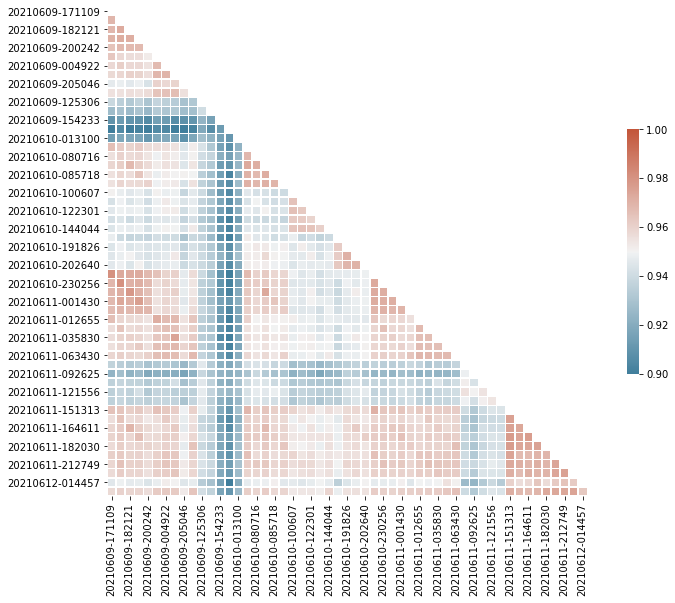

In [6]:
corr = oofs[pred_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0.9, vmax=1.0, # center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [7]:
scores = cross_val_score(
#     LinearRegression(),
    Ridge(alpha=100),
#     BayesianRidge(),
    oofs[pred_cols],
    oofs["target"],
    scoring="neg_mean_squared_error",
#     cv=LeaveOneOut(),
    n_jobs=-1,
)
print(f"Best score: {np.sqrt(np.mean(-scores)):0.5f}")

Best score: 0.45553


# Brute force model selection

In [9]:
# def powerset(iterable):
#     "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
#     s = list(iterable)  # allows duplicate elements
#     return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

# subsets = list(powerset(pred_cols))
# len(subsets)

In [10]:
# best_score = 10
# best_cols = None

# for s in tqdm(subsets[1:]):
#     reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000))
#     reg.fit(oofs[list(s)], oofs["target"])
#     score = np.sqrt(-reg.best_score_)
    
#     if score < best_score:
#         best_score = score
#         best_cols = list(s)
        
# print(f"Best score: {best_score:0.5f}")
# print("Best cols", best_cols)

In [11]:
# ['model_1', 'model_2', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_11', 'model_13', 'model_16']

# Hill climbing

In [12]:
def get_score(X, y):
    reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000))
    reg.fit(X, y)
    return np.sqrt(-reg.best_score_)

In [15]:
candidates = model_folders.copy()

best_score = np.inf
selection = []
# tol = 0.00001
tol = 0
y = oofs["target"]

# Find best initial model
initial_scores = [np.sqrt(mean_squared_error(oofs[c], oofs["target"])) for c in candidates]
idx = np.argmin(initial_scores)
best_score = initial_scores[idx]
selection.append(candidates[idx])
print(f"Initial {candidates[idx]}. Score {best_score:0.5f}")
del candidates[idx]


while True:
    scores = [get_score(oofs[selection + [c]], y) for c in candidates]
    idx = np.argmin(scores)
    if scores[idx] < best_score - tol:
        best_score = scores[idx]
        selection.append(candidates[idx])
        print(f"Added {candidates[idx]}. New best score {best_score:0.5f}")
        del candidates[idx]
    else:
        break
        
print(len(selection), "models selected")
        
selection

Initial 20210611-212749. Score 0.48442
Added 20210609-020213. New best score 0.46663
Added 20210610-144044. New best score 0.46140
Added 20210610-222705. New best score 0.45859
Added 20210611-155942. New best score 0.45729
Added 20210610-133140. New best score 0.45665
Added 20210609-200242. New best score 0.45608
Added 20210611-012655. New best score 0.45568
Added 20210610-085718. New best score 0.45545
Added 20210610-013100. New best score 0.45518
Added 20210611-233646. New best score 0.45504
Added 20210610-100607. New best score 0.45489
Added 20210611-024254. New best score 0.45472
Added 20210610-000227. New best score 0.45464
Added 20210610-233847. New best score 0.45454
Added 20210610-074205. New best score 0.45448
Added 20210611-001430. New best score 0.45446
Added 20210610-080716. New best score 0.45438
Added 20210609-182121. New best score 0.45435
Added 20210611-164611. New best score 0.45428
20 models selected


['20210611-212749',
 '20210609-020213',
 '20210610-144044',
 '20210610-222705',
 '20210611-155942',
 '20210610-133140',
 '20210609-200242',
 '20210611-012655',
 '20210610-085718',
 '20210610-013100',
 '20210611-233646',
 '20210610-100607',
 '20210611-024254',
 '20210610-000227',
 '20210610-233847',
 '20210610-074205',
 '20210611-001430',
 '20210610-080716',
 '20210609-182121',
 '20210611-164611']

In [ ]:
selection = [
#     # complex-heron-of-science - roberta-base
#     "20210609-171109",  # deleted
#     "20210609-174639",
    "20210609-182121",
#     "20210609-192843",  # deleted
    "20210609-200242",
#     # impetuous-marvellous-cockle - roberta-large
#     "20210608-233655",  # deleted
#     "20210609-004922",  # deleted
    "20210609-020213",
#     "20210609-205046",  # deleted
#     "20210609-220344",  # deleted
#     # zippy-caped-leech - albert-large
#     "20210609-125306",  # deleted
#     "20210609-141352",  # deleted
#     "20210609-154233",
    "20210610-000227",
    "20210610-013100",
#     # armored-cobalt-crow - distill roberta
    "20210610-074205",
    "20210610-080716",
#     "20210610-083206",  # deleted
    "20210610-085718",
#     "20210610-093912",  # deleted
#     # big-slug-of-tranquility - funnel transformer
    "20210610-100607",
#     "20210610-111551",  # deleted
#     "20210610-122301",  # deleted
    "20210610-133140",
    "20210610-144044",
#     # nocturnal-winged-lionfish - bert-base-uncased
#     "20210610-184414",
#     "20210610-191826",
#     "20210610-195230",
#     "20210610-202640",
#     # adaptable-scallop-of-anger - roberta-base (hidden)
    "20210610-222705",
#     "20210610-230256",
    "20210610-233847",
    "20210611-001430",
#     "20210611-005055",
#     # fluffy-dandelion-skua - roberta-large (hidden)
    "20210611-012655",
    "20210611-024254",
#     "20210611-035830",
#     "20210611-051501",
#     "20210611-063430",
#     # gregarious-classic-yak - albert-large (hidden)
#     "20210611-080150",
#     "20210611-092625",
#     "20210611-105105",
#     "20210611-121556",
#     "20210611-134040",
#     # serious-outrageous-caribou - deberta-base
#     "20210611-151313",
    "20210611-155942",  # This seed seems amazing
    "20210611-164611",
#     "20210611-173302",
#     "20210611-182030",
#     # ostrich-of-abstract-art - deberta-large
#     "20210611-191919",
    "20210611-212749",
    "20210611-233646",
#     "20210612-014457",
#     "20210612-035134",
]

In [ ]:
model_folders = [
    "20210611-212749",
    "20210609-020213",
    "20210610-144044",
    "20210610-222705",
    "20210611-155942",
    "20210610-133140",
    "20210609-200242",
    "20210611-012655",
    "20210610-085718",
    "20210610-013100",
    "20210611-233646",
    "20210610-100607",
    "20210611-024254",
    "20210610-000227",
    "20210610-233847",
    "20210610-074205",
    "20210611-001430",
    "20210610-080716",
    "20210609-182121",
    "20210611-164611",
]